 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms


Скачаем обучающую и контрольную выборки.

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
])

In [ ]:
trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=24,
                                          shuffle=True, num_workers=2)

testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=24,
                                         shuffle=False, num_workers=2)

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress",
           "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

## Анализ датасета

### 1 задание

In [ ]:
print("train size:", trainset.data.shape[0])
print("test size:", testset.data.shape[0])

train size: 60000
test size: 10000


### 2 задание

In [ ]:
trainset.targets.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [ ]:
testset.targets.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

### 3 задание

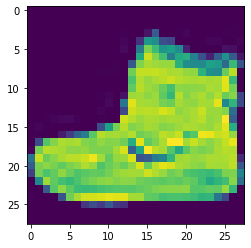

In [ ]:
plt.imshow(trainset.data[0])

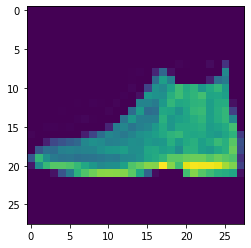

In [ ]:
plt.imshow(testset.data[0])

## Shared

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
input_size = trainset.data[0].reshape(-1).shape[0]
output_size = len(classes)

learning_rate = 1e-3

In [ ]:
def show_classification(img, net):
    net = net.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(12, 15), ncols=2)
    ax1.imshow(img.cpu().resize_(1, 28, 28).numpy().squeeze())
    ax1.axis("off")
    ax2.barh(np.arange(10), net)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size="small");
    ax2.set_title("Вероятность класса")
    ax2.set_xlim(0, 1)

In [ ]:
def train(model, epochs=5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  losses = []

  for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    
    for X_batch, y_batch in trainloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X_batch)

        # Подсчет loss
        loss = criterion(y_pred, y_batch)
        running_loss += loss.item()

        loss.backward()

        # Обновление весов
        optimizer.step()
    else:
      losses.append(running_loss / len(trainloader.sampler))
  
  return losses

In [ ]:
def accuracy(model):
  correct = 0
  total = 0

  with torch.no_grad():
    model.eval()

    for X_batch, y_batch in testloader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      outputs = model(X_batch)
      predicted = torch.max(outputs.data, 1)[1]
      total += y_batch.size(0)
      correct += (predicted == y_batch).sum().item()

  return 100 * correct // total

## Multi-Layer Perceptron

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(input_size, 512)
    self.fc2 = nn.Linear(512, 256)
    self.out = nn.Linear(256, output_size)

  def forward(self, x):
    x = x.view(x.shape[0], -1)

    x = self.fc1(x)
    x = self.relu(x)

    x = self.fc2(x)
    x = self.relu(x)

    x = self.out(x)

    return F.log_softmax(x, dim=1)

In [ ]:
model_mlp = MLP().to(device)

model_mlp

MLP(
  (relu): ReLU()
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
train_losses_mlp = train(model_mlp)

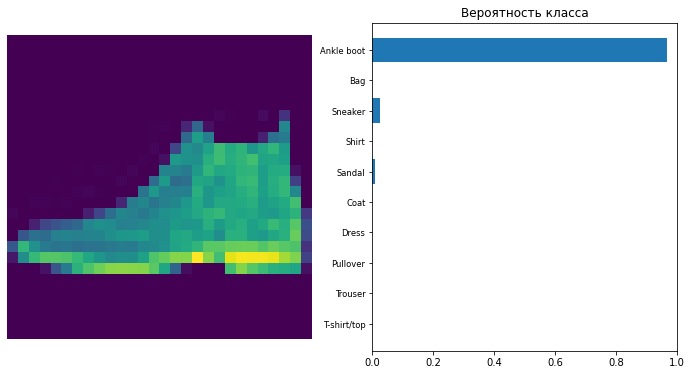

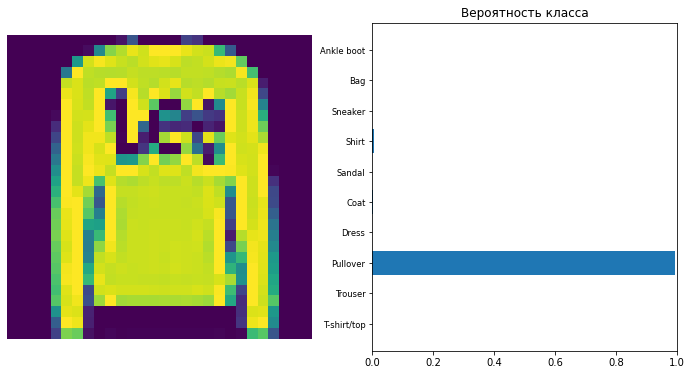

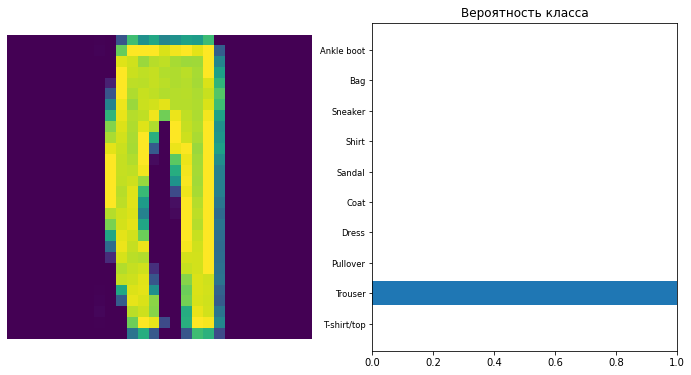

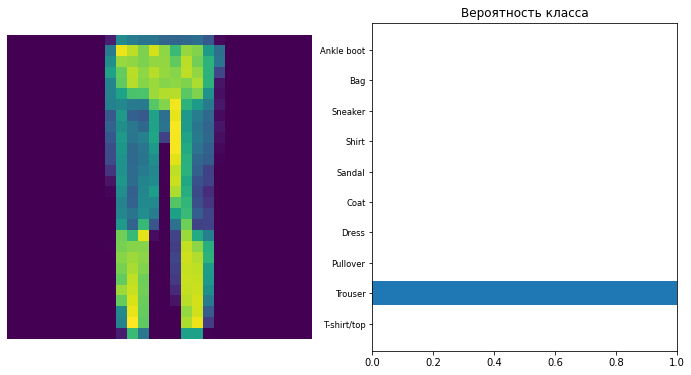

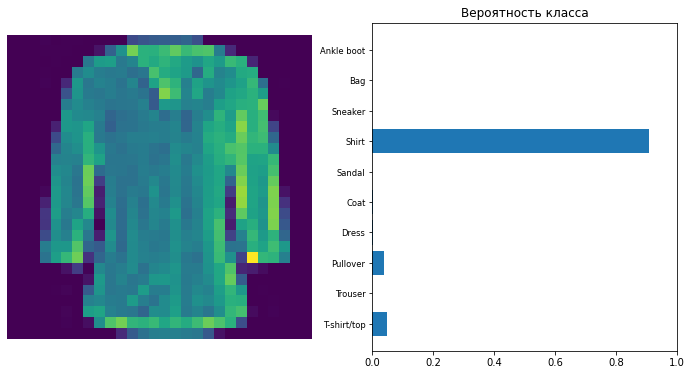

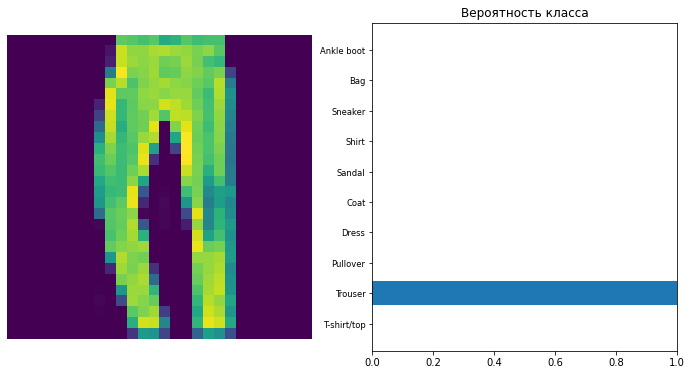

In [ ]:
dataiter = iter(testloader)
images, _ = next(dataiter)

for i in range(len(images.to(device)) // 4):
  img = images.to(device)[i]
  img = img.view(1, 784)

  with torch.no_grad():
    output = model_mlp.forward(img)

  net = torch.exp(output)
  show_classification(img.view(1, 28, 28), net)

## Сверточная сеть

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc1 = nn.Linear(in_features=4 * 4 * 64, out_features=256)
    self.out = nn.Linear(in_features=256, out_features=output_size)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1, 4 * 4 * 64)
    x = self.fc1(x)
    x = F.relu(x)

    x = self.out(x)
        
    return F.log_softmax(x, dim=1)

In [ ]:
model_cnn = CNN().to(device)

model_cnn

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
train_losses_cnn = train(model_cnn)

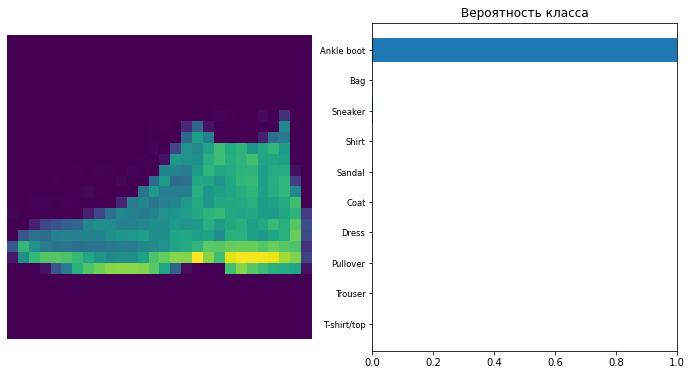

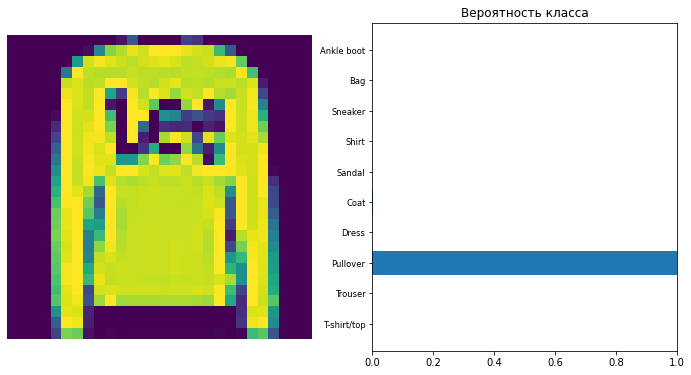

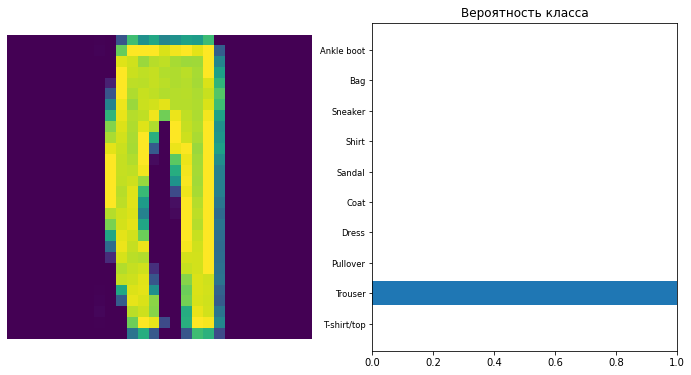

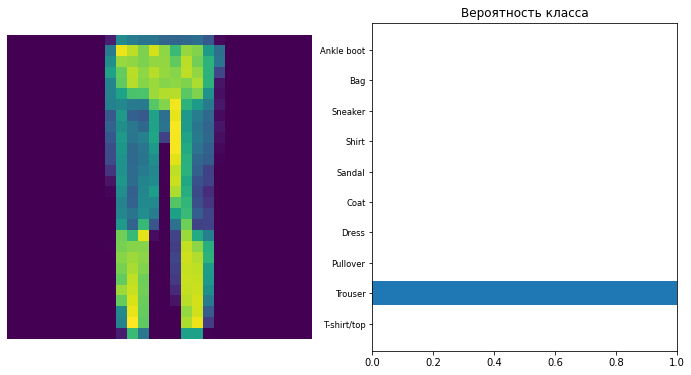

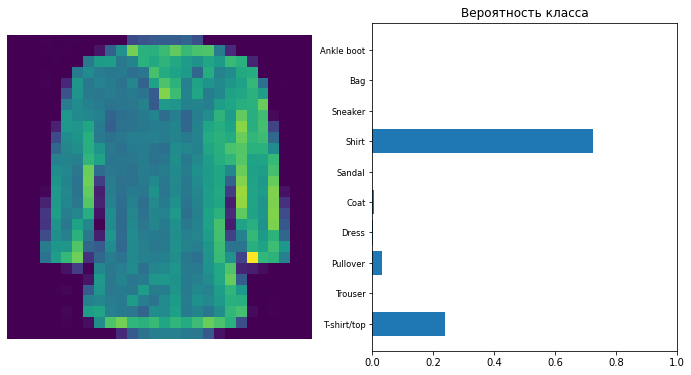

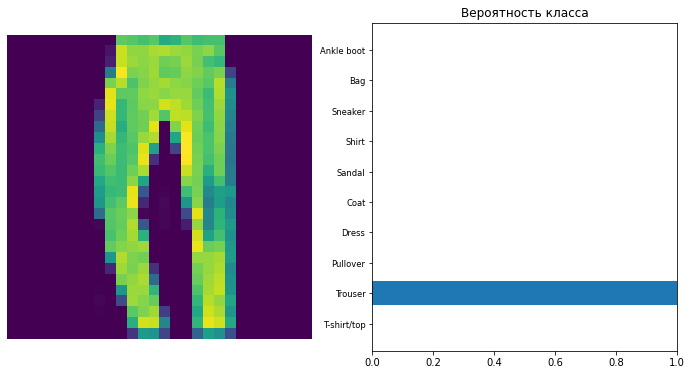

In [ ]:
dataiter = iter(testloader)
images, _ = next(dataiter)

for i in range(len(images.to(device)) // 4):
  img = images.to(device)[i]

  with torch.no_grad():
    output = model_cnn.forward(img)

  net = torch.exp(output)
  show_classification(img.view(1, 28, 28), net)

## Сравнение сетей

### Loss

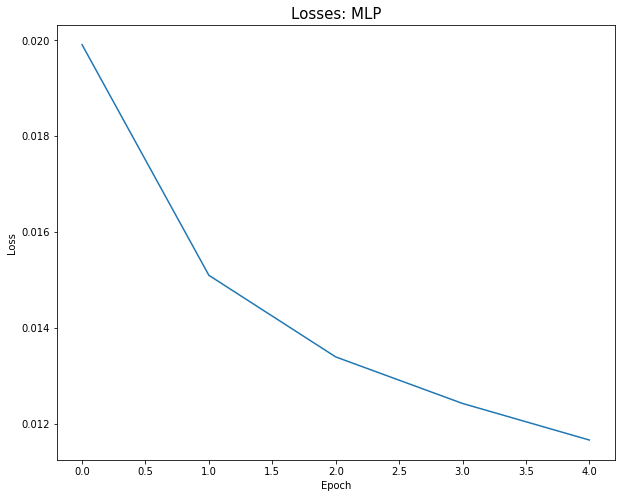

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses_mlp)
plt.title('Losses: MLP', fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

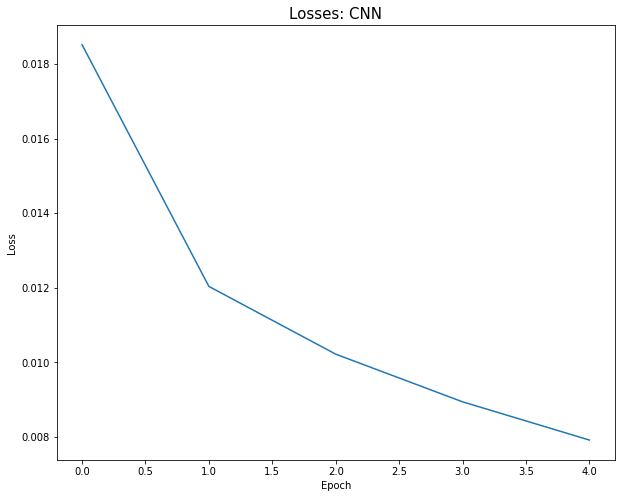

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses_cnn)
plt.title('Losses: CNN', fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Accuracy

In [ ]:
print(f"Accuracy MLP: {accuracy(model_mlp)} %")

Accuracy MLP: 88 %


In [ ]:
print(f"Accuracy CNN: {accuracy(model_cnn)} %")

Accuracy CNN: 91 %
